In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, "..")
sys.path.insert(0, "../..")

# PaiNN 
This tutorial gives an example of implementing the [equivariant PaiNN architecture](https://arxiv.org/pdf/2102.03150.pdf)

First we import dependencies for the tutorial:

In [2]:
import sys
from pathlib import Path

import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import copy

import torch
from torch.optim import Adam
from torch.utils.data import DataLoader
from torch.utils.data.sampler import RandomSampler


from nff.data import Dataset, split_train_validation_test, collate_dicts, to_tensor
from nff.train import Trainer, get_trainer, get_model, load_model, loss, hooks, metrics, evaluate

First we make a directory for our work and load the ethanol dataset:

In [3]:
DEVICE = 0
OUTDIR = './sandbox_painn'
# batch size used in the original paper
BATCH_SIZE = 10

if os.path.exists(OUTDIR):
    newpath = os.path.join(os.path.dirname(OUTDIR), 'backup')
    if os.path.exists(newpath):
        shutil.rmtree(newpath)
        
    shutil.move(OUTDIR, newpath)
    
dataset = Dataset.from_file('data/dataset.pth.tar')
train, val, test = split_train_validation_test(dataset, val_size=0.2, test_size=0.2,
                                              seed=0)

Now we make the model. Note that we can use the mean and standard deviation of the energy in the training set to scale the outputs of the model:

In [4]:
modelparams = {"feat_dim": 128,
              "activation": "swish",
              "n_rbf": 20,
              "cutoff": 5.0,
              "num_conv": 3,
              "output_keys": ["energy"],
              "grad_keys": ["energy_grad"],
               # whether to sum outputs from all blocks in the model
               # or just the final output block. False in the original
               # implementation
              "skip_connection": {"energy": False},
               # Whether the k parameters in the Bessel basis functions
               # are learnable. False originally
              "learnable_k": False,
               # dropout rate in the convolution layers, originally 0
               "conv_dropout": 0.0,
               # dropout rate in the readout layers, originally 0
               "readout_dropout": 0.0,
               # dictionary of means to add to each output key
               # (this is optional - if you don't supply it then
               # nothing will be added)
               "means": {"energy": train.props['energy'].mean().item()},
               # dictionary of standard devations with which to 
               # multiply each output key
               # (this is optional - if you don't supply it then
               # nothing will be multiplied)
               "stddevs": {"energy": train.props['energy'].std().item()}
              }
model = get_model(modelparams, model_type="Painn")

# untrained model to test for equivariant/invariant outputs
original_model = copy.deepcopy(model)

Next we make the training splits, loaders, and trainer
- Remember to use a random sampler for the train loader, because that makes a big difference in the results (at least for small datasets)

In [5]:

train_loader = DataLoader(train, batch_size=BATCH_SIZE, collate_fn=collate_dicts,
                         sampler=RandomSampler(train))

val_loader = DataLoader(val, batch_size=BATCH_SIZE, collate_fn=collate_dicts)
test_loader = DataLoader(test, batch_size=BATCH_SIZE, collate_fn=collate_dicts)

# loss trade-off used in the original paper
loss_fn = loss.build_mse_loss(loss_coef={'energy_grad': 0.95, 'energy': 0.05})

trainable_params = filter(lambda p: p.requires_grad, model.parameters())

# learning rate used in the original paper
optimizer = Adam(trainable_params, lr=1e-3)


train_metrics = [
    metrics.MeanAbsoluteError('energy'),
    metrics.MeanAbsoluteError('energy_grad')
]


train_hooks = [
    hooks.MaxEpochHook(100),
    hooks.CSVHook(
        OUTDIR,
        metrics=train_metrics,
    ),
    hooks.PrintingHook(
        OUTDIR,
        metrics=train_metrics,
        separator = ' | ',
        time_strf='%M:%S'
    ),
    hooks.ReduceLROnPlateauHook(
        optimizer=optimizer,
        # patience in the original paper
        patience=50,
        factor=0.5,
        min_lr=1e-7,
        window_length=1,
        stop_after_min=True
    )
]

T = Trainer(
    model_path=OUTDIR,
    model=model,
    loss_fn=loss_fn,
    optimizer=optimizer,
    train_loader=train_loader,
    validation_loader=val_loader,
    checkpoint_interval=1,
    hooks=train_hooks,
    mini_batches=1
)

Now we train and see the results!

In [6]:
T.train(device=DEVICE, n_epochs=50)

 Time | Epoch | Learning rate | Train loss | Validation loss | MAE_energy | MAE_energy_grad | GPU Memory (MB)


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 59/60 [00:04<00:00, 12.57it/s]


50:40 |     1 |     1.000e-03 |   104.6426 |         35.8928 |     1.3957 |          4.3919 |              53


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 59/60 [00:04<00:00, 12.81it/s]


50:45 |     2 |     1.000e-03 |    24.8587 |         20.1787 |     2.1709 |          3.3579 |              53


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 59/60 [00:04<00:00, 12.20it/s]


50:51 |     3 |     1.000e-03 |    14.6834 |         15.2948 |     1.8712 |          2.9489 |              53


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 59/60 [00:04<00:00, 12.38it/s]


50:56 |     4 |     1.000e-03 |    14.0037 |         10.8184 |     0.7811 |          2.5381 |              53


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 59/60 [00:04<00:00, 12.44it/s]


51:02 |     5 |     1.000e-03 |    10.2829 |          8.8013 |     2.0512 |          2.2229 |              53


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 59/60 [00:04<00:00, 12.28it/s]


51:08 |     6 |     1.000e-03 |    11.8799 |         10.7772 |     0.7171 |          2.4730 |              53


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 59/60 [00:04<00:00, 12.27it/s]


51:13 |     7 |     1.000e-03 |     7.2207 |          5.7647 |     1.3713 |          1.7525 |              53


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 59/60 [00:05<00:00, 10.73it/s]


51:20 |     8 |     1.000e-03 |     6.2374 |          5.4644 |     0.6772 |          1.7618 |              53


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 59/60 [00:05<00:00, 10.35it/s]


51:27 |     9 |     1.000e-03 |     4.7774 |          7.0971 |     0.7005 |          1.8925 |              53


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 59/60 [00:05<00:00, 10.35it/s]


51:33 |    10 |     1.000e-03 |     4.4307 |          5.7723 |     0.9024 |          1.8400 |              53


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 59/60 [00:06<00:00,  9.82it/s]


51:40 |    11 |     1.000e-03 |     4.6491 |          5.6558 |     1.5259 |          1.7586 |              53


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 59/60 [00:04<00:00, 12.25it/s]


51:46 |    12 |     1.000e-03 |     4.5384 |          4.6967 |     0.7911 |          1.6179 |              53


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 59/60 [00:04<00:00, 12.50it/s]


51:52 |    13 |     1.000e-03 |     3.5612 |          5.6514 |     0.7319 |          1.7251 |              53


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 59/60 [00:04<00:00, 12.81it/s]


51:57 |    14 |     1.000e-03 |     4.8459 |          4.3679 |     0.6616 |          1.5538 |              53


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 59/60 [00:04<00:00, 13.06it/s]


52:02 |    15 |     1.000e-03 |     4.7874 |          4.9432 |     0.5342 |          1.6184 |              53


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 59/60 [00:04<00:00, 12.24it/s]


52:08 |    16 |     1.000e-03 |     3.5366 |          3.3033 |     0.5949 |          1.3329 |              53


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 59/60 [00:04<00:00, 12.41it/s]


52:14 |    17 |     1.000e-03 |     2.8693 |          3.5463 |     0.4968 |          1.3950 |              53


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 59/60 [00:04<00:00, 11.84it/s]


52:20 |    18 |     1.000e-03 |     2.2900 |          2.8676 |     0.4697 |          1.2603 |              53


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 59/60 [00:04<00:00, 12.73it/s]


52:25 |    19 |     1.000e-03 |     1.8572 |          3.5191 |     0.5053 |          1.4538 |              53


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 59/60 [00:04<00:00, 12.95it/s]


52:30 |    20 |     1.000e-03 |     2.2247 |          3.3322 |     0.4162 |          1.3760 |              53


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 59/60 [00:05<00:00, 11.75it/s]


52:36 |    21 |     1.000e-03 |     2.2692 |          3.4537 |     0.4160 |          1.3745 |              53


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 59/60 [00:04<00:00, 12.35it/s]


52:42 |    22 |     1.000e-03 |     2.2595 |          3.0126 |     0.4343 |          1.2782 |              53


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 59/60 [00:04<00:00, 12.41it/s]


52:48 |    23 |     1.000e-03 |     2.5160 |          3.1114 |     1.0502 |          1.2860 |              53


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 59/60 [00:04<00:00, 12.15it/s]


52:53 |    24 |     1.000e-03 |     2.0448 |          3.2757 |     0.4253 |          1.3663 |              53


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 59/60 [00:04<00:00, 12.85it/s]


52:59 |    25 |     1.000e-03 |     2.1274 |          2.8919 |     0.6743 |          1.2026 |              53


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 59/60 [00:04<00:00, 12.04it/s]


53:05 |    26 |     1.000e-03 |     1.9718 |          2.6598 |     0.6956 |          1.1884 |              53


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 59/60 [00:04<00:00, 12.22it/s]


53:10 |    27 |     1.000e-03 |     1.7271 |          2.7245 |     0.3771 |          1.2327 |              53


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 59/60 [00:05<00:00, 11.78it/s]


53:16 |    28 |     1.000e-03 |     2.5700 |          3.7693 |     0.5218 |          1.3995 |              53


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 59/60 [00:05<00:00, 11.08it/s]


53:22 |    29 |     1.000e-03 |     2.1624 |          2.8310 |     0.5908 |          1.2286 |              53


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 59/60 [00:05<00:00, 11.46it/s]


53:28 |    30 |     1.000e-03 |     2.3878 |          3.7281 |     0.7295 |          1.3752 |              53


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 59/60 [00:05<00:00, 11.79it/s]


53:34 |    31 |     1.000e-03 |     2.4486 |          3.9171 |     0.4891 |          1.5428 |              53


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 59/60 [00:04<00:00, 12.00it/s]


53:40 |    32 |     1.000e-03 |     1.9909 |          2.7623 |     0.4314 |          1.2030 |              53


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 59/60 [00:04<00:00, 12.91it/s]


53:45 |    33 |     1.000e-03 |     1.3829 |          2.2207 |     0.4187 |          1.0630 |              53


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 59/60 [00:04<00:00, 12.49it/s]


53:51 |    34 |     1.000e-03 |     1.6256 |          2.1504 |     0.7927 |          1.0498 |              53


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 59/60 [00:04<00:00, 12.92it/s]


53:56 |    35 |     1.000e-03 |     1.3646 |          2.2046 |     0.3780 |          1.0779 |              53


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 59/60 [00:04<00:00, 13.25it/s]


54:02 |    36 |     1.000e-03 |     1.6907 |          2.5707 |     0.3310 |          1.1942 |              53


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 59/60 [00:04<00:00, 11.91it/s]


54:08 |    37 |     1.000e-03 |     1.3743 |          2.2210 |     0.2689 |          1.1090 |              53


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 59/60 [00:04<00:00, 12.33it/s]


54:13 |    38 |     1.000e-03 |     1.4463 |          2.2205 |     0.4318 |          1.0839 |              53


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 59/60 [00:04<00:00, 13.20it/s]


54:18 |    39 |     1.000e-03 |     1.3386 |          2.6689 |     0.5784 |          1.2062 |              53


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 59/60 [00:04<00:00, 12.84it/s]


54:24 |    40 |     1.000e-03 |     1.5063 |          2.2579 |     0.4589 |          1.0841 |              53


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 59/60 [00:04<00:00, 13.89it/s]


54:28 |    41 |     1.000e-03 |     1.5443 |          2.5127 |     0.3745 |          1.1543 |              53


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 59/60 [00:02<00:00, 22.51it/s]


54:31 |    42 |     1.000e-03 |     1.4072 |          1.9840 |     0.3366 |          1.0172 |              53


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 59/60 [00:02<00:00, 26.09it/s]


54:34 |    43 |     1.000e-03 |     1.3038 |          2.7495 |     0.3688 |          1.2444 |              53


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 59/60 [00:02<00:00, 23.61it/s]


54:37 |    44 |     1.000e-03 |     1.4283 |          2.1873 |     0.4449 |          1.0756 |              53


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 59/60 [00:02<00:00, 22.76it/s]


54:40 |    45 |     1.000e-03 |     1.5195 |          2.2718 |     0.4458 |          1.0732 |              53


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 59/60 [00:02<00:00, 21.26it/s]


54:43 |    46 |     1.000e-03 |     1.6631 |          2.0960 |     0.6345 |          1.0568 |              53


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 59/60 [00:02<00:00, 20.13it/s]


54:47 |    47 |     1.000e-03 |     1.3507 |          1.7552 |     1.4381 |          0.9448 |              53


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 59/60 [00:03<00:00, 18.86it/s]


54:51 |    48 |     1.000e-03 |     1.7653 |          2.5372 |     1.2032 |          1.1152 |              53


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 59/60 [00:04<00:00, 14.64it/s]


54:55 |    49 |     1.000e-03 |     2.1702 |          2.5157 |     0.3266 |          1.2236 |              53


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 59/60 [00:03<00:00, 15.84it/s]


55:00 |    50 |     1.000e-03 |     2.1654 |          2.8966 |     0.3810 |          1.2571 |              53


Check that the energies are invariant to rotations and that the gradients are equivariant:

In [10]:
from numpy import cos, sin

def make_rot(alpha, beta, gamma):
    """
    Make a general rotation matrix from angles alpha, beta and gamma
    """
    r = torch.Tensor([
        [cos(alpha) * cos(beta),
        cos(alpha) * sin(beta) * sin(gamma) - sin(alpha) * cos(gamma),
        cos(alpha) * sin(beta) * cos(gamma) + sin(alpha) * sin(gamma)],
        [sin(alpha) * cos(beta),
        sin(alpha) * sin(beta) * sin(gamma) + cos(alpha) * cos(gamma),
        sin(alpha) * sin(beta) * cos(gamma) - cos(alpha) * sin(gamma)],
        [-sin(beta), cos(beta) * sin(gamma), cos(beta) * cos(gamma)]
    ])
    
    return r
    
# test that an arbitrary rotation matrix is unitary
r = make_rot(0.2, 0.1, 0.4)
print(torch.matmul(r, r.transpose(0, 1)))

tensor([[ 1.0000e+00, -3.5184e-09,  3.8562e-09],
        [-3.5184e-09,  1.0000e+00, -6.5784e-09],
        [ 3.8562e-09, -6.5784e-09,  1.0000e+00]])


In [11]:
# get results for a geometry and its rotated version

nxyz = train.props['nxyz'][0]
rots = [torch.diag(torch.ones(3)), make_rot(1.4, -0.5, 1.3)]
original_model.to(DEVICE)

for rot in rots:
    xyz = torch.stack([torch.matmul(rot, i[1:]) for i in nxyz])
    z = nxyz[:, 0].reshape(-1, 1)
    this_nxyz = torch.cat([z, xyz], dim=-1).to(DEVICE)
    batch = {"nxyz": this_nxyz,
             "num_atoms": torch.LongTensor([len(nxyz)]),
             "nbr_list": train.props['nbr_list'][0].to(DEVICE)}
    results = original_model(batch)
    energy = results['energy'].cpu()
    
    # energies should be invariant
    print("%.8f " % energy.item())
    
    energy_grad = results['energy_grad'].cpu()
        
    # applying R^T to the gradients should give the same value for
    # all geometries
    rot_grad = torch.stack([torch.matmul(rot.transpose(0, 1), 
                                         i) for i in energy_grad])
    print(rot_grad)

53.97652435 
tensor([[12.5535,  4.2386,  5.0381],
        [-8.4048, -7.3581,  2.3932],
        [ 6.9726,  6.3975,  3.5584],
        [ 0.8526,  0.8563, -6.7881],
        [ 5.0760, 10.2634,  3.1802],
        [-7.9873, -0.6507,  0.5244],
        [-0.1297, -1.6504, -6.9545],
        [-0.7030, -4.9541,  2.7618],
        [-8.2299, -7.1424, -3.7135]], grad_fn=<StackBackward>)
53.97652817 
tensor([[12.5535,  4.2386,  5.0381],
        [-8.4047, -7.3581,  2.3932],
        [ 6.9726,  6.3975,  3.5584],
        [ 0.8526,  0.8563, -6.7881],
        [ 5.0760, 10.2633,  3.1802],
        [-7.9873, -0.6507,  0.5244],
        [-0.1297, -1.6504, -6.9545],
        [-0.7030, -4.9541,  2.7618],
        [-8.2299, -7.1424, -3.7135]], grad_fn=<StackBackward>)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 28.28it/s]


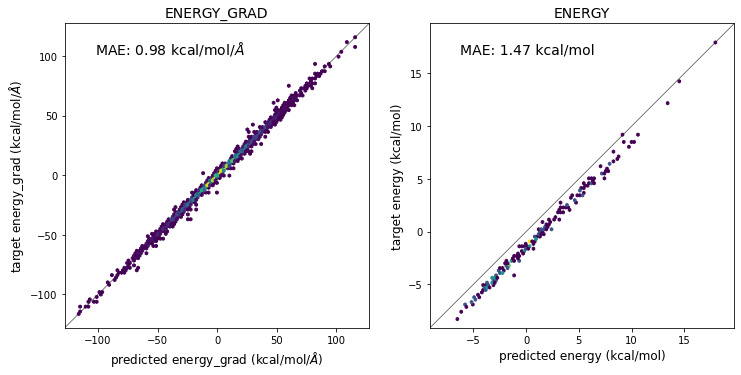

In [12]:
results, targets, val_loss = evaluate(T.get_best_model(), 
                                      test_loader, 
                                      loss_fn, 
                                      device=DEVICE)

units = {
    'energy_grad': r'kcal/mol/$\AA$',
    'energy': 'kcal/mol'
}

fig, ax_fig = plt.subplots(1, 2, figsize=(12, 6))

for ax, key in zip(ax_fig, units.keys()):
    pred_fn = torch.cat
    targ_fn = torch.cat
    if all([len(i.shape) == 0 for i in results[key]]):
        pred_fn = torch.stack
    if all([len(i.shape) == 0 for i in targets[key]]):
        targ_fn = torch.stack
        
    pred = pred_fn(results[key], dim=0).view(-1).detach().cpu().numpy()
    targ = targ_fn(targets[key], dim=0).view(-1).detach().cpu().numpy()

    mae = abs(pred-targ).mean()
    
    ax.hexbin(pred, targ, mincnt=1)
    
    lim_min = min(np.min(pred), np.min(targ)) * 1.1
    lim_max = max(np.max(pred), np.max(targ)) * 1.1
    
    ax.set_xlim(lim_min, lim_max)
    ax.set_ylim(lim_min, lim_max)
    ax.set_aspect('equal')
    
    ax.plot((lim_min, lim_max),
            (lim_min, lim_max),
            color='#000000',
            zorder=-1,
            linewidth=0.5)
    
    ax.set_title(key.upper(), fontsize=14)
    ax.set_xlabel('predicted %s (%s)' % (key, units[key]), fontsize=12)
    ax.set_ylabel('target %s (%s)' % (key, units[key]), fontsize=12)
    ax.text(0.1, 0.9, 'MAE: %.2f %s' % (mae, units[key]), 
           transform=ax.transAxes, fontsize=14)

plt.show()

Note that PaiNN is about 30x more efficient than DimeNet (efficiency = 1 / (inference time * memory footprint)), with even better accuracy. The improved accuracy is reported in the PaiNN paper, and we have confirmed this accuracy by training our DimeNet and PaiNN implementations on aspirin in the MD17 dataset.